# How to handle tool calling errors

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling">
                    Tool calling
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/">
                    Deleting messages
                </a>
            </li>
        </ul>
    </p>
</div> 

Calling tools with an LLM is generally more reliable than pure prompting, but it isn't perfect. The model may try to call a tool that doesn't exist or fail to return arguments that match the requested schema. Strategies like keeping schemas simple, reducing the number of tools you pass at once, and having good names and descriptions can help mitigate this risk, but aren't foolproof.

This guide covers some ways to build error handling into your graphs to mitigate these failure modes.

## Using the prebuilt `ToolNode`

To start, define a mock weather tool that has some hidden restrictions on input queries. The intent here is to simulate a real-world case where a model fails to call a tool correctly:

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [2]:
from langchain_core.tools import tool

@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if "san francisco" in location.lower():
        raise ValueError("Only abbreviations are accepted for input queries")
    elif "sf" in location.lower():
        return ["It's 60 degrees and foggy."]
    else:
        raise ValueError('Invalid input.')

Next, set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll use the prebuilt [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to execute called tools, and a small, fast model powered by Anthropic:

In [3]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([get_weather])

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0).bind_tools([get_weather])

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

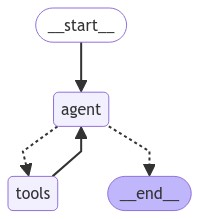

In [4]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

When you try to call the tool, you can see that the model calls the tool with a bad input, causing the tool to throw an error. The prebuilt `ToolNode` that executes the tool has some built-in error handling that captures the error and passes it back to the model so that it can try again:

In [5]:
app.invoke(
    {"messages": [("human", "what is the weather in san francisco?")]},
)

{'messages': [HumanMessage(content='what is the weather in san francisco?', id='e01a13ce-990b-4024-9348-f403d9e67ceb'),
  AIMessage(content=[{'id': 'toolu_01AGWxEdGFt9QCiptczcZTe5', 'input': {'location': 'san francisco'}, 'name': 'get_weather', 'type': 'tool_use'}], response_metadata={'id': 'msg_01MWJtvsshdWEX3DBzN9zF2a', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 333, 'output_tokens': 54}}, id='run-60535c91-027e-4388-ad56-97b472609115-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'san francisco'}, 'id': 'toolu_01AGWxEdGFt9QCiptczcZTe5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 333, 'output_tokens': 54, 'total_tokens': 387}),
  ToolMessage(content="Error: ValueError('Only abbreviations are accepted for input queries')\n Please fix your mistakes.", name='get_weather', id='cbf46d90-66da-4631-aba2-dc0e899835e4', tool_call_id='toolu_01AGWxEdGFt9QCiptczcZTe5'),
  AIMessage(content=[{'text': 'Ok

## Custom strategies

This is a fine default in many cases, but there are cases where custom fallbacks may be better.

For example, the below tool requires as input a list of elements of a specific length - tricky for a small model! We'll also intentionally avoid pluralizing `topic` to trick the model into thinking it should pass a string:

In [20]:
from langchain_core.output_parsers import StrOutputParser
from langchain.pydantic_v1 import BaseModel, conlist

class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)

@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku

tool_node = ToolNode([master_haiku_generator])

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
model_with_tools = model.bind_tools([master_haiku_generator])

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10}
)

{'messages': [HumanMessage(content='Write me an incredible haiku about water.', id='22724a00-952a-45d1-b3db-50bed4334297'),
  AIMessage(content=[{'text': 'Here is a haiku about water:', 'type': 'text'}, {'id': 'toolu_01XDWDVEci7MfVbjDjKgRUDG', 'input': {'topic': ['water']}, 'name': 'master_haiku_generator', 'type': 'tool_use'}], response_metadata={'id': 'msg_01NNbazuHvDTXCsLs9jRQWHN', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 384, 'output_tokens': 67}}, id='run-78b85d96-d32b-4d44-b633-e050ecff8a4d-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'topic': ['water']}, 'id': 'toolu_01XDWDVEci7MfVbjDjKgRUDG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 384, 'output_tokens': 67, 'total_tokens': 451}),
  ToolMessage(content="Error: ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request',), 'msg': 'field required', 'type': 'value_error.missing'}])\n Please fix your mistakes.", 

We can see that the model takes multiple tries to get the input correct.

A better strategy might be to trim the failed attempt to reduce distraction, then fall back to a more advanced model. Here's an example. We also use a custom-built node to call our tools instead of the prebuilt `ToolNode`:

In [21]:
import json

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage

class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)

@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku

def call_tool(state: MessagesState):
    tools_by_name = {
        master_haiku_generator.name: master_haiku_generator
    }
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        try:
            tool_result = tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # Return the error if the tool call fails
            output_messages.append(
                ToolMessage(
                    content="",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={
                        "error": e
                    }
                )
            )
    return {"messages": output_messages}

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
model_with_tools = model.bind_tools([master_haiku_generator])

better_model = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)
better_model_with_tools = better_model.bind_tools([master_haiku_generator])

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def should_fallback(state: MessagesState) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [msg for msg in messages if isinstance(msg, ToolMessage) and msg.additional_kwargs.get("error") is not None]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(i for i, msg in reversed(list(enumerate(messages))) if isinstance(msg, AIMessage))
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}

# Fallback agent with a better model triggered if
# a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()

The above graph adds a new cycle that handles errors, shown by the diagram below:

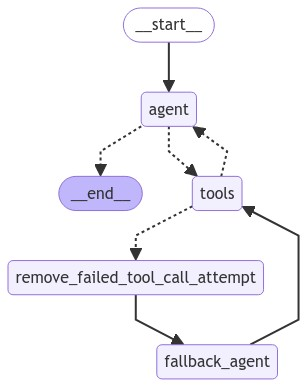

In [22]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

This time if we call it, we get a cleaner response as the more powerful model gets it right on the first try. This shorter message history also avoid overpopulating the graph state with attempts:

In [23]:
app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10}
)

{'messages': [HumanMessage(content='Write me an incredible haiku about water.', id='cf8c9e79-9f13-4696-9af6-0a352eed917b'),
  AIMessage(content=[{'text': 'Certainly! I\'d be happy to help you create an incredible haiku about water. To do this, we\'ll use the master_haiku_generator function, which requires three topics. Since you\'ve specified water as the main theme, I\'ll add two related concepts to create a more vivid and interesting haiku. Let\'s use "water," "flow," and "reflection" as our three topics.\n\nHere\'s the function call to generate your haiku:', 'type': 'text'}, {'id': 'toolu_014fPTtLuqWtHZgQWTfk5Z71', 'input': {'request': {'topic': ['water', 'flow', 'reflection']}}, 'name': 'master_haiku_generator', 'type': 'tool_use'}], response_metadata={'id': 'msg_0183tGgfZaqWaqErGwwXtXtx', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 414, 'output_tokens': 163}}, id='run-c0db9908-f3b7-4c07-be1d-d5e2fd55f864-0', to

Check out this [LangSmith trace](https://smith.langchain.com/public/9530be1e-af23-4c06-816d-1649485251c9/r), which shows the failed initial call to the smaller model.

## Next steps

You've now seen how to implement some strategies to handle tool calling errors.

Next, check out some of the [other LangGraph how-to guides here](https://langchain-ai.github.io/langgraph/how-tos/).